<a href="https://colab.research.google.com/github/gideonkipkorir/Mental-Health-Challange/blob/master/Mental_Healtchallenge_tensorflor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libriaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv('/content/Train (4).csv')
train.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [ ]:
test = pd.read_csv('/content/Test (3).csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      616 non-null    object
 1   text    616 non-null    object
 2   label   616 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB


In [ ]:
train.isnull().sum()

ID       0
text     0
label    0
dtype: int64

In [ ]:
train.duplicated().any()

False

In [ ]:
#CLEANING texts to get rid of punctuation
# train.text = train.text.str.replace('[^a-zA-Z0-9]', ' ')
# train.text = train['text'].map(lambda x: x.lower())

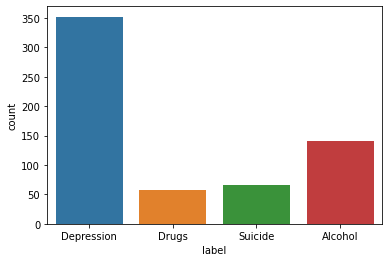

In [ ]:
sns.countplot(x= train.label, data = train  )

In [ ]:
df_drugs = train[train.label=='Drugs']
df_depression = train[train.label == 'Depression']
df_suicide = train[train.label =='Suicide']
df_alcohol = train[train.label == 'Alcohol']
print('depression cases are {}'.format(len(df_depression)))
print('Drug cases are {}'.format(len(df_drugs)))
print('sucide cases are {}'.format(len(df_suicide)))
print('Alchohol cases are {}'.format(len(df_alcohol)))

depression cases are 352
Drug cases are 58
sucide cases are 66
Alchohol cases are 140


In [ ]:
#the dataset is so imbalance am going to try and sample them equally
depression_sample = df_depression.sample(80) #sampling 80 texts
alcohol_sample = df_alcohol.sample(80)

In [ ]:
balance_df = pd.concat([depression_sample, alcohol_sample, df_suicide, df_drugs], axis = 0)
balance_df = balance_df.sample(frac=1).reset_index(drop=True)#shaffling the data

In [ ]:
# train.label = train.label.replace({'Drugs':1, 'Depression':2, 'Suicide':3, 'Alcohol':4})

In [ ]:
!nvidia-smi #checking properties of the allocated gpu

Sat Jul  4 14:02:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |    819MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow_text

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 31kB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf
from tensorflow import keras

In [ ]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [ ]:
#Preprocessing
# from sklearn.preprocessing import OneHotEncoder
y = OneHotEncoder(sparse=False).fit_transform(
  balance_df.label.to_numpy().reshape(-1, 1)
)

In [ ]:
#Spliting the dataset into train and test datasets
# x_train, x_test, y_train,y_test = train_test_split(balance_df.text, y, test_size = 0.1, random_state =45)

In [ ]:
#sentence encoding x_train tweets
X_train = []
for tweets in tqdm(x_train):
  emb = use(tweets)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 255/255 [00:05<00:00, 44.72it/s]


In [ ]:
#sentence encoding x_test tweets
X_test = []
for r in tqdm(x_test):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 29/29 [00:00<00:00, 74.10it/s]


In [ ]:
test_dt = []
for r in tqdm(test.text):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  test_dt.append(review_emb)

test_dt= np.array(test_dt)

100%|██████████| 309/309 [00:03<00:00, 80.81it/s]


In [ ]:
print(X_train.shape, y_train.shape)

(255, 512) (255, 4)


In [ ]:
print(X_test.shape, y_test.shape)

(29, 512) (29, 4)


In [ ]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.6
)
)
model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(4, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.2, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 1.3561 - accuracy: 0.3431 - val_loss: 1.3150 - val_accuracy: 0.4902
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 1.2557 - accuracy: 0.6324 - val_loss: 1.1815 - val_accuracy: 0.6471
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 1.0854 - accuracy: 0.7353 - val_loss: 0.9799 - val_accuracy: 0.7255
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 0.8416 - accuracy: 0.8088 - val_loss: 0.7659 - val_accuracy: 0.8039
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 0.6326 - accuracy: 0.8529 - val_loss: 0.6101 - val_accuracy: 0.8431
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 0.4878 - accuracy: 0.8627 - val_loss: 0.5360 - val_accuracy: 0.8235
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 0.4045 - accuracy: 0.8971 - val_loss: 0.5250 - val_accuracy: 0.8431
Epoch 8/10
13/13 [=

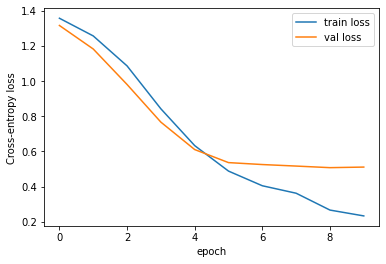

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

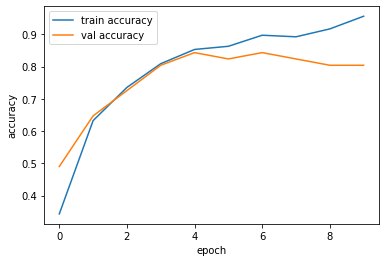

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.2791 - accuracy: 0.8966


[0.2790721356868744, 0.8965517282485962]

In [ ]:
pred = model.predict(test_dt)
samp = pd.DataFrame(pred, columns=['Alcohol', 'Depresssion', 'Drugs', 'Suicide'])
s = pd.concat([test.drop(['text'],1), samp],axis = 1)
s.head()

,ID,Alcohol,Depresssion,Drugs,Suicide
0,02V56KMO,0.040868,0.361292,0.015991,0.581848
1,03BMGTOK,0.002784,0.930762,0.001375,0.065079
2,03LZVFM6,0.004995,0.953139,0.002779,0.039087
3,0EPULUM5,0.001679,0.985577,0.000869,0.011876
4,0GM4C5GD,0.067682,0.005159,0.918923,0.008236


In [ ]:
s[['Depresssion','Alcohol', 'Suicide','Drugs']]= s[['Depresssion','Alcohol', 'Suicide','Drugs']].round().astype(int)
s = s[['ID','Depresssion','Alcohol', 'Suicide','Drugs']]
s.to_csv('submission.csv')

In [ ]:
s.head()

,ID,Depresssion,Alcohol,Suicide,Drugs
0,02V56KMO,1,0,0,0
1,03BMGTOK,1,0,0,0
2,03LZVFM6,1,0,0,0
3,0EPULUM5,1,0,0,0
4,0GM4C5GD,0,0,0,1
